## Intro

This is a supervised classification algorithm based on the idea that histograms are kind of like an approximation of the probability density function for a random variable.

The main benifet of this approach is that the learning process should extremely parallelizable, so it should scale quite well to large data sets.

### Learning Process
* $H_+ = $ histogram for positive datapoints
* $H_- = $ histogram for negative datapoints
* $H = H_+ - H_- = $ activation function. spans [-1,1]

In [38]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from time import time
from NaiveModel import Naive

In [64]:
''' Shuffles feature matrix and labels in case they are ordered '''
def shuffle(x,y):
    z = list(zip(x,y))
    np.random.shuffle(z)
    x,y = zip(*z)
    return np.array(x),np.array(y)

''' Splits feature matrix and labels into training and testing data '''
def split(x,y,split_percentage):
    split_idx = int(len(y)*split_percentage)
    z = list(zip(x,y))
    z1 = z[:split_idx]
    z2 = z[split_idx:]
    x1,y1 = zip(*z1)
    x2,y2 = zip(*z2)
    return np.array(x1),np.array(y1),np.array(x2),np.array(y2)

''' Generates 2 normally distributed clusters to be used as positive and negative examples '''
def gen_random(p_size, n_size, dims):
    p_mean = np.random.randint(50, size = dims)
    n_mean = np.random.randint(50, size = dims)
    p_sig = (np.random.randint(3, size = dims)+1)*3
    n_sig = (np.random.randint(3, size = dims)+1)*3

    p_data = np.random.normal(p_mean, p_sig, (p_size,dims))
    n_data = np.random.normal(n_mean, n_sig, (n_size,dims))
    labels = np.array([1]*p_size+[0]*n_size)

    data = np.vstack((p_data,n_data))
    data,labels = shuffle(data,labels)
    return data,labels


''' 
performs binary classification over X with the provided model 
    and prints out some useful info
'''
def evaluate(model, X, y):
    X,y = shuffle(X,y)
    x_train, y_train, x_test, y_actual = split(X,y,.70)
    model = model()
    plt.scatter(x_test[:,0],x_test[:,1],cmap = 'cividis', c = y_actual, marker = '.')
    plt.title("Actual")
    plt.show()
    t0 = time()
    model.fit(x_train,y_train)
    t1 = time()
    
    # Shows the decision boundary for each dimension
    #model.plotActivations()

    y_predict = model.predict(x_test)
    t2 = time()
    correct = y_predict == y_actual
    accuracy = correct.sum()/correct.shape[0]
    fp = (y_predict-1 == y_actual).sum()/(y_predict.sum())
    tn = (y_predict+1 == y_actual).sum()/((y_predict-1).sum()*-1)
    print("Accuracy: {}\nFalse Positives: {}\nTrue Negatives: {}\nTime to fit: {}\nTime to predict: {}".format(accuracy,fp, tn, t1-t0, t2-t1))
    plt.scatter(x_test[:,0],x_test[:,1],cmap = 'cividis', c = y_predict, marker = '.')
    plt.title("Predictions")
    plt.show()
    
def p_y_given_x(x,y,bins,show_hist = False):
    positive_idxs = np.where(y==1)[0]
    negative_idxs = np.where(y==0)[0]
    x_p = x[positive_idxs]
    x_n = x[negative_idxs]
    h_p, b_p = np.histogram(x_p,bins,range=(x.min(),x.max()))
    h_n, b_n = np.histogram(x_n,bins,range=(x.min(),x.max()))
    
    ''' Computationally expensive '''
#     h = h_p + h_n + 1
#     p_y = np.divide(h_p,h)
    
    ''' Faster, but behaves poorly sometimes '''
    h_p = h_p/x_p.shape[0]
    h_n = h_n/x_n.shape[0]
    p_y = h_p - h_n


    if show_hist:
        plt.plot(b_n[1:],p_y)
    return p_y,b_n[1:]


### The Data

We'll start off looking at two small, nicely separated, gaussian distributions

In [70]:
data,labels = gen_random(100, 100, 2)

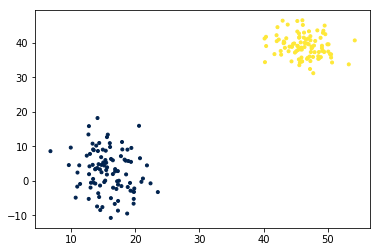

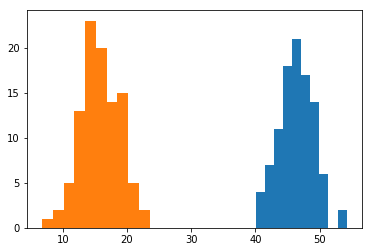

In [71]:
plt.scatter(data[:,0],data[:,1],cmap = 'cividis', c = labels, marker = '.')
plt.show()

p_data = data[np.where(labels==1)[0]]
n_data = data[np.where(labels==0)[0]]
plt.hist(p_data[:,0])
plt.hist(n_data[:,0])
plt.show()

### Basic Inspiration
The two histograms above (blue and orange) can be thought of as un-normalized pdfs for the two clusters. For this explanation we are going to ignore the y dimension. The basic argument this model is making is that the probability of being a member of the blue distribution is greatest when the likelyhood of being in A is greatest and the likelyhood of being in B is lowest.

The simplest activation function upholding this argument is the $O(x) = L(A|x) - L(B|x)$.

Below is a plot of the activation function for the x coordinate of the data we made above

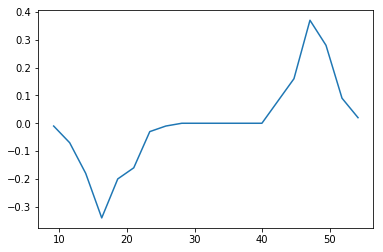

In [72]:
x = data[:,0]
y = labels


p_y,bins = p_y_given_x(x,y,20)

plt.plot(bins,p_y)
plt.show()

Accuracy: 1.0


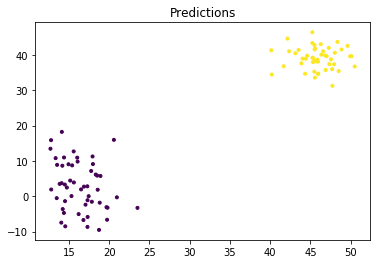

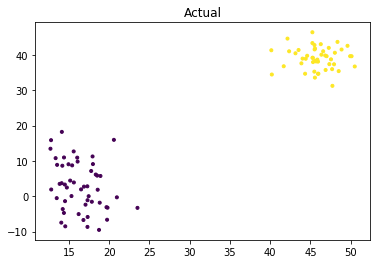

In [73]:
x_train, y_train, x_test, y_test = split(data,labels,0.5)

model = Naive()
model.fit(x_train,y_train)


y_predict = model.predict(x_test)

print("Accuracy:", (y_predict == y_test).mean())
plt.scatter(x_test[:,0], x_test[:,1], c = y_predict,marker = '.')
plt.title("Predictions")
plt.show()
plt.scatter(x_test[:,0], x_test[:,1], c = y_test, marker = '.')
plt.title("Actual")
plt.show()



## Ok, now lets see how this model performs for more interesting distributions

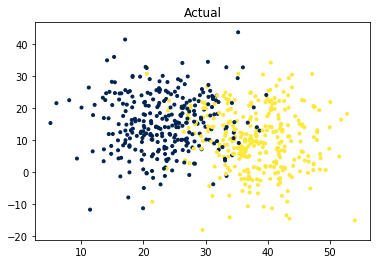

Accuracy: 0.87
False Positives: 0.10380622837370242
True Negatives: 0.15434083601286175
Time to fit: 0.0014095306396484375
Time to predict: 0.00010275840759277344


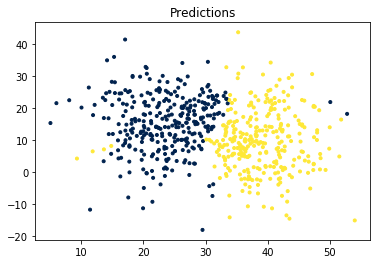

In [47]:
X,y = gen_random(1000, 1000, 2)
evaluate(Naive, X,y)

### Disproportionate occurances

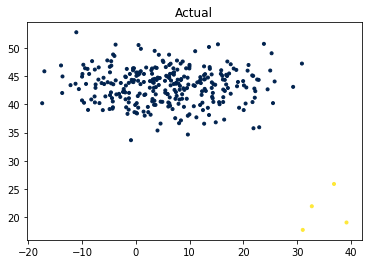

Accuracy: 0.9801980198019802
False Positives: 0.6
True Negatives: 0.0
Time to fit: 0.0010542869567871094
Time to predict: 8.416175842285156e-05


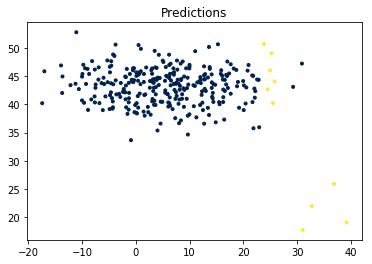

In [48]:
X,y = gen_random(10, 1000, 2)
evaluate(Naive, X,y)

### Overlapping

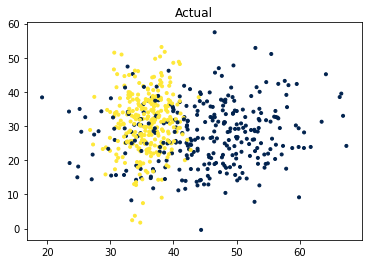

Accuracy: 0.7916666666666666
False Positives: 0.2838541666666667
True Negatives: 0.07407407407407407
Time to fit: 0.0012366771697998047
Time to predict: 0.00012230873107910156


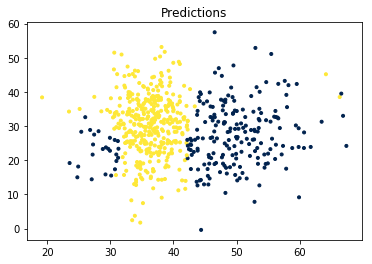

In [50]:
X,y = gen_random(1000, 1000, 2)
evaluate(Naive, X,y)

### Large dataset (2 Million datapoints)

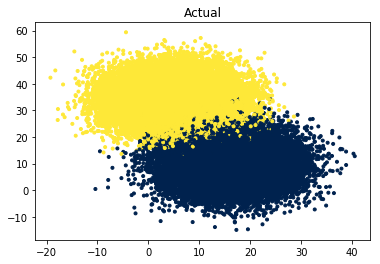

Accuracy: 0.9544666666666667
False Positives: 0.058003509456034316
True Negatives: 0.032402655170054064
Time to fit: 0.014928579330444336
Time to predict: 0.005138397216796875


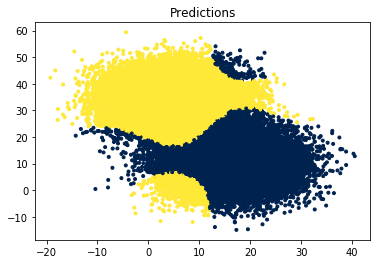

In [51]:
X,y = gen_random(100000, 100000, 2)
evaluate(Naive, X,y)

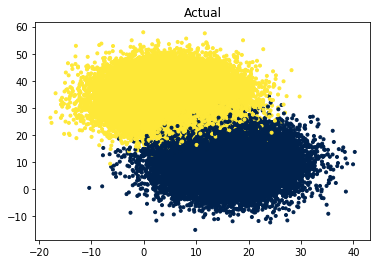

Accuracy: 0.9863166666666666
False Positives: 0.01347664048981765
True Negatives: 0.013890743956190731
Time to fit: 0.030874967575073242
Time to predict: 0.007288217544555664


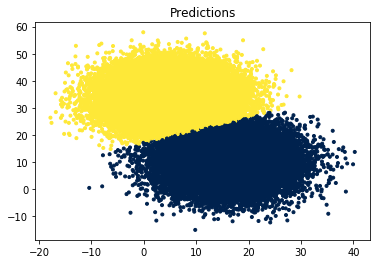

In [52]:
evaluate(GaussianNB, X,y)

### Higher Dimensions

Gaussian Naive Bayes pulls ahead on high dimensional data.
200,000 datapoints with 1,000 dimension

But we also see that the addition of more dimensions reduces the strange behavior seen in the 2D examples

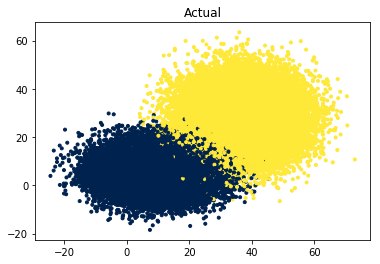

Accuracy: 0.9999333333333333
False Positives: 3.340236488743403e-05
True Negatives: 9.979375956356863e-05
Time to fit: 0.09046292304992676
Time to predict: 0.02220606803894043


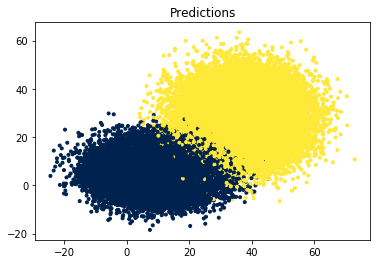

In [62]:
X,y = gen_random(100000, 100000, 10)
evaluate(Naive, X,y)

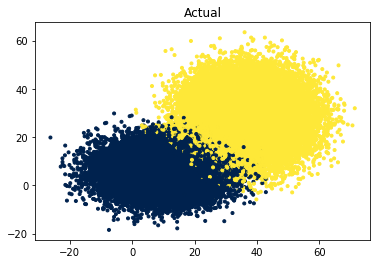

Accuracy: 1.0
False Positives: 0.0
True Negatives: 0.0
Time to fit: 0.04860258102416992
Time to predict: 0.0124664306640625


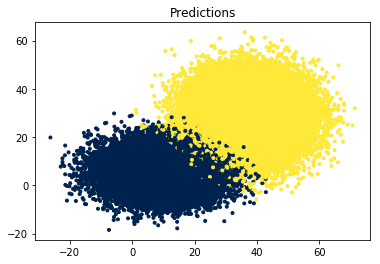

In [63]:
evaluate(GaussianNB, X,y)